In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [2]:
# Colebrook-White equation function to solve for friction factor f
def colebrook(Re, ks_D):
    # Initial guess for friction factor (Blasius correlation for smooth pipe)
    f = 0.079 / Re**0.25
    # Iterative solution for Colebrook-White equation
    for i in range(100):
        f_new = 1 / (-1 * np.log10((ks_D / 3.7) + (5.02 / (Re * np.sqrt(f)))))
        if abs(f_new - f) < 1e-6:  # Convergence criterion
            f = f_new
            break
        f = f_new
    Cf = f 
    return Cf

# Define the sample size
n_samples = 100000  # or any desired number
mu        = 0.001  # Example constant value in Pa.s
## IF REYNOLDS NUMBER AND RELATIVE ROUGHNESS ARE LOG UNIFORM DISTRIBUTED
log_Re                 = np.random.uniform(3, 5, n_samples)  
log_relative_roughness = np.random.uniform(-8, -0.7, n_samples)  
Re                     = 10**log_Re
relative_roughness     = 10**log_relative_roughness
rho = 200  # Example constant density (kg/m^3)
D   = np.random.uniform(1, 10, n_samples)
k   = relative_roughness * D  # Roughness height (m)
U   = (Re * mu) / (rho * D)  # Velocity (m/s)
Cf  = np.zeros(n_samples)
for i in range(n_samples):
    Cf[i] = colebrook(Re[i], relative_roughness[i])
print(f'Relative roughness range: {relative_roughness.min()} - {relative_roughness.max()}')
print(f'Reynolds number range: {Re.min()} - {Re.max()}')    

Relative roughness range: 1.0004768225450387e-08 - 0.19952291176578119
Reynolds number range: 1000.0000725082373 - 99992.38591626064


In [3]:
X              = np.column_stack((U, rho * np.ones(n_samples), D, k, mu * np.ones(n_samples)))
# Output matrix Y (Skin Friction Coefficient Cf)
y              = Cf.reshape(-1, 1)
D_in           = np.matrix('1 -3 1 1 -1; -1 0 0 0 -1; 0 1 0 0 1')
variables_tauw = ['u', '\\rho', 'D', 'k','\\mu'];
num_input      = 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train         = y_train.squeeze()
y_test         = y_test.squeeze()

# Optional: Print the shapes of the resulting datasets to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80000, 5)
X_test shape: (20000, 5)
y_train shape: (80000,)
y_test shape: (20000,)


In [18]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    def __init__(self, X, y, scaling_mat):
        super(DimensionlessLearning, self).__init__()
        self.X, self.y = X, y
        self.scaling_mat = scaling_mat
        self.basis_num = scaling_mat.shape[1]

    def parse_power_index(self, basis_coef):
        '''
        parse power index based on basis coefficients
        '''
        power_index = np.sum(np.multiply(self.scaling_mat, basis_coef), axis=1)
        return power_index

    def scale_input(self, X, basis_coef):
        '''
        scale the the input data into a few dimensionless numbers
        '''
        power_index = self.parse_power_index(basis_coef)
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        return X_scaled, power_index

    def parse_feats(self, X, deg=5):
        '''
        prepare different degrees' features
        '''
        poly = PolynomialFeatures(deg)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        return X_poly

    def predict(self, X, power_index, scaling_coef, deg=5):
        '''
        based on learned basis coefficients and scaling coefficients to predict
        '''
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        X_poly = self.parse_feats(X_scaled, deg)
        pred = np.sum(np.multiply(X_poly, scaling_coef), axis=1)
        return pred

    def fit(self, method='pattern_search', init_point_num=20, seed=0):
        '''
        fit the dataz
        '''
        BASE = 2 ** 20
        r2, basis_coef, scaling_coef = 0, None, None
        
        for idx in range(init_point_num):
            seed = (idx + seed * init_point_num) % BASE

            if method == 'pattern_search':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_pattern_search(seed=seed)
            elif method == 'gradient_descent':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_gradient_descent(seed=seed)
                print('r2_temp, basis_coef_temp, scaling_coef_temp', r2_temp, basis_coef_temp, scaling_coef_temp)
            else:
                raise Exception('Error in the optimizaiton method')

            if r2_temp < r2:
                continue
            r2, basis_coef, scaling_coef = r2_temp, basis_coef_temp, scaling_coef_temp

        return r2, basis_coef, scaling_coef

    def _opt(self, basis_coef):
        '''
        fit a linear regression
        '''
        # prepare polynomial features based on dimensionless numbers
        X_scaled, power_index = self.scale_input(self.X, basis_coef)
        X_poly = self.parse_feats(X_scaled)

        # fit a polynomial
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X_poly, self.y)
        y_pred = reg.predict(X_poly)
        r2 = r2_score(self.y, y_pred)
        scaling_coef = reg.coef_

        return r2, power_index, scaling_coef

    def fit_pattern_search(self, gamma0=0.5, max_iter=10, grid_range=[-2, 2], grid_interval=0.1, clip_threshold=0.2, seed=0):
        '''
        pattern search-based optimization

        Args:
            gamma0 [float]: basis coefficient for the first basis vector;
            max_iter [int]: the maximum iteration for pattern search;
            grid_range [list of int]: the range for each basis coefficient;
            grid_interval [float]: the grid interval for each basis coefficient;
            clip_threshold [float]: if the R2 score for the initial point is lower than this threshold, break the loop;
        Return:
            r2 [float]: the final R2 score
            power_index [array]: the power law index for one input dimensionless nunber
            scaling_coef [array]: the scaling law coefficients
        '''
        def _get_coordinates(basis_num, basis_coef, grid_interval):
            '''
            build a list to store all possible coordiantes
            '''
            # prepare grid
            param_grid = {}
            center_coord = []
            coord_all = []
            for i in range(basis_num):
                gamma_value = basis_coef[i]
                param_grid[f'gamma{i}'] = [gamma_value-grid_interval, gamma_value, gamma_value+grid_interval]
                center_coord.append(gamma_value)
            
            # build grid
            grid = ParameterGrid(param_grid)
            for params in grid:
                coord = []
                for i in range(basis_num):
                    coord.append(params[f'gamma{i}'])
                if coord != center_coord:
                    coord_all.append(coord)
            return coord_all

        def _init_basis_coef(basis_num, grid_range, grid_interval, gamma0):
            '''
            initialize basis coefficient
            '''
            grid_num = int((grid_range[1] - grid_range[0]) / grid_interval + 1)
            basis_coef = np.zeros((basis_num))
            for i in range(basis_num):
                basis_coef[i] = np.random.choice(np.linspace(grid_range[0], grid_range[1], grid_num), 1)[0]  # [-2, 2]
                # basis_coef[i] = 1
            basis_coef[0] = gamma0
            return basis_coef

        # initial basis coefficients
        np.random.seed(seed)
        basis_coef = _init_basis_coef(self.basis_num, grid_range, grid_interval, gamma0)

        # randomly initialize different center points
        iter_num = 0
        while iter_num < max_iter:
            candidate_coord = _get_coordinates(self.basis_num, basis_coef, grid_interval)
            # calculate the center point
            r2_center, power_index_center, scaling_coef_center = self._opt(basis_coef)
            # print('r2_center', round(r2_center, 4), 'power_index_center', [round(each, 2) for each in list(power_index_center.reshape(-1,))])

            # break if the initial point has a low R2 score
            if r2_center < clip_threshold:
                break
            
            # calculate the neighboring points
            r2_bounds_val = []
            for gamma_list in candidate_coord:
                basis_coef_temp = np.array(gamma_list)
                r2_bound, power_index_bound, scaling_coef_bound = self._opt(basis_coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort the R2 score for neighboring points from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes if the neighboring point has a higher R2 score
            if r2_center < r2_bounds_val[highest_index]:
                basis_coef = np.array(candidate_coord[highest_index])
                power_index = self.parse_power_index(basis_coef)
                # res_info = {'gamma_list': gamma_list, 'r2_center': round(r2_bounds_val[highest_index], 4)}
            else:
                break

        # calcualte the final R2 and coefficients
        r2, power_index, scaling_coef = self._opt(basis_coef)

        return r2, power_index, scaling_coef

[Dataset] X_train: (80000, 5), y_train: (80000,)
[Dataset] X_test: (20000, 5), y_test: (20000,)
[Training]
Final r2: 0.0999, power_index: [-0.8 -0.8 -0.3 -0.5  0.8], scaling_coef: [ 4.11631778e-01 -2.44764156e-01  2.00448460e-01 -6.60678448e-02
  1.13624774e-02 -1.13697415e-03  6.96773249e-05 -2.64940506e-06
  6.09162323e-08 -7.75103941e-10  4.18734006e-12]
[Visualization]


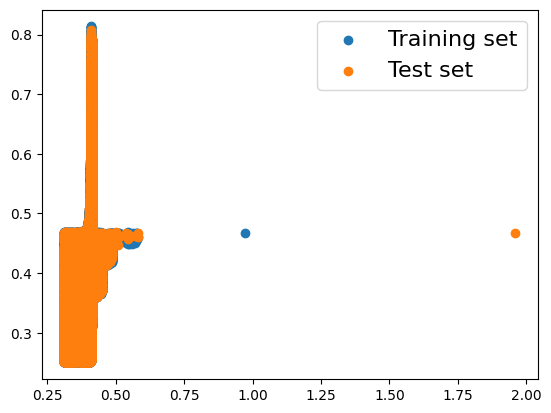

In [17]:
def test_Rayleigh_example(method):
    '''
    Rayleigh problem
    '''
    ################################### config ###################################
    
    
    # dimension matrix

    D_out = np.array(
        [
            [0.],
            [0.],
            [0.],
            [0.],
            [0.],
        ]
    )
    # best weights for Ke: 0.5, 1, 1
    # basis vectors in columns
    scaling_mat = np.array(
            [[ 0.,  0.,  1., -1.,  0.],
        [ 1.,  1.,  1.,  0., -1.]],
           
    ).T
    deg = 5

    ################################### dataset ########################################
    # load, split, and shuffle the dataset
    #data_loader = Dataset(dataset_path, input_list, output_list)
    #X_train, y_train, X_test, y_test = data_loader.parser()
    print(f'[Dataset] X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] X_test: {X_test.shape}, y_test: {y_test.shape}')

    ################################### training and testing ###########################
    print('[Training]')
    dimensionless_learning = DimensionlessLearning(X_train, y_train, scaling_mat)
    r2, power_index, scaling_coef = dimensionless_learning.fit(method=method)
    print(f'Final r2: {r2:.4f}, power_index: {power_index}, scaling_coef: {scaling_coef}')
    pred_train = dimensionless_learning.predict(X_train, power_index, scaling_coef, deg)
    pred_test = dimensionless_learning.predict(X_test, power_index, scaling_coef, deg)

    ################################### visualization ###################################
    print('[Visualization]')
    fig = plt.figure()
    plt.scatter(pred_train, y_train, label='Training set')
    plt.scatter(pred_test, y_test, label='Test set')
    plt.legend(fontsize=16)
    plt.show()


method = 'pattern_search'
test_Rayleigh_example(method)
#variables_tauw = ['u', '\\rho', 'D', 'k','\\mu'];
